# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 
    
---

**Requirements**

In [1]:
!conda install python-graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
!pip install torchview

In [3]:
!nvidia-smi

Wed Apr 12 09:46:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:E3:00.0 Off |                    0 |
|  0%   43C    P0    92W / 300W |      0MiB /  5067MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
#### Imports 

In [1]:
# Visualization
import matplotlib.pyplot as plt
from torchview import draw_graph

# Modeling
import numpy as np
import torch
import torchvision
#import torchvision.transforms as transforms
from torch import nn


# Others
from tqdm.auto import tqdm

## 1. Data Gathering & Pre-Processing

### 1.1 Data Augmentation
Training data variations are created by data Augmentation.

In [2]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    torchvision.transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    torchvision.transforms.RandomRotation(10),     #Rotates the image to a specified angel
    torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    torchvision.transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = torchvision.transforms.Compose([
    #torchvision.transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(size=[32,32], padding=4),
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),
    #torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2),
    #torchvision.transforms.RandomResizedCrop(size=(32, 32)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train_3 = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(*stats,inplace=True)
])
transform_val_3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats)])

In [3]:
transform_train = transform_train_3
transform_val = transform_val_3

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print test and train dataset properties
trainset, testset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

### 1.2 Data Loader

In [5]:
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### 1.3 Check data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


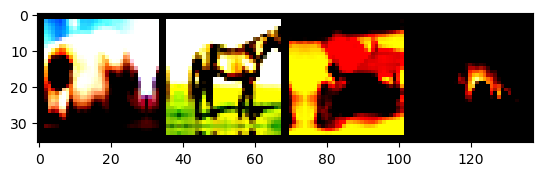

dog   horse plane deer 


In [6]:
# Code reused from Pytorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [7]:
# print size of data

images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

## 2. Model Architecture

Given below is a basic required architecture.


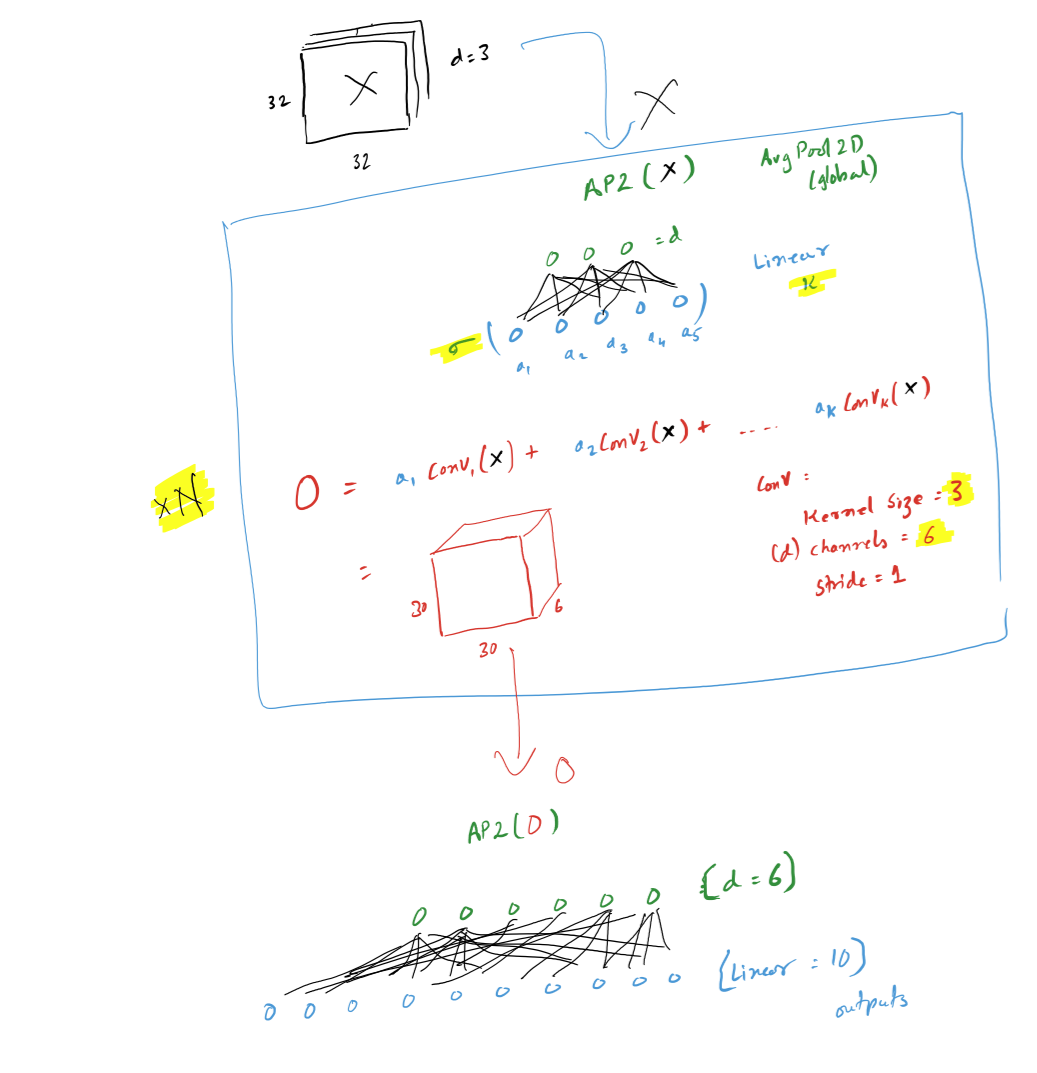

This architecture is further updated with additional parameters like dropouts, normalization etc to help aid in modeling.

In [8]:
# Parameters 

N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

### 2.1 ConvLayer

In [9]:
class ConvLayer(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Convolution Block.
        """
        
        super(ConvLayer, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout2d(p=0.1),
        )

### 2.2 ConvBlock

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        TODO
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(*[
            ConvLayer(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size)
            for i in range(len(channels) - 1)
        ])


    def forward(self, x):
        #return self.relu(self.batch_norm(self.conv_block(x) + self.conv(x)))
        return self.conv_block(x)


### 2.3 Backbone

In [11]:
class Backbone(nn.Module):

    def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        """
        Backbone Block, having K ConvBlocks returning weighted sum. weights calculated using linear transformation of adaptiveAvgPool (spatial average pool).
        """
            
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.mlp = nn.Sequential(
            nn.Linear(in_features=channels[0], out_features=k, bias=True),   # Question, can this be MLP?
            #nn.Tanh(),
            #nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
            #nn.BatchNorm1d(k),
        )

        self.parallel_conv_blocks = nn.ModuleList([
            ConvBlock(channels=channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=channels[-1])

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.mlp(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.parallel_conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        out = self.batch_norm(out)
        if self.debug: print(f"batch_{out.shape=}")

        return out

### 2.4 Classifier

In [12]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        """
        Classifer, to classify the CIFAR 10 dataset. it has SpatialAveragePool and an linear layer.
        """
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=True),
            #nn.Dropout(p=0.1),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=True),
            #nn.Dropout(p=0.1),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=True),
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

### 2.5 Model

In [13]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        """
        Model, having N Backbones and a classifer.
        """
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.Sequential(*[
            Backbone(
                channels=self.channels[i],
                #self.channels[i], 
                #out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1][-1], out_features=len(CLASSES), debug=debug)

    @property
    def device(self):
        return next(self.parameters()).device
    
    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        x = self.backbones(x)
        out = self.classifier(x)
        return out

## 3 Trainer

In [14]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4) -> None:
        """
        Trainer to help in training of the model.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False, grad_clip=None):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            
            # Set model to training.
            self.model.train()
            
            # Train loop
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                
                # Transfer data to cuda.
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                if grad_clip: nn.utils.clip_grad_value_(self.model.parameters(), grad_clip)
                
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            #print(f"Train Loss : {self.losses[-1]}")
            
            # Calculate accuracy
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            #print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            val_loss, val_accuracy = self.eval()
            self.scheduler.step(val_loss)
            
            print(f"LR : {self.lrs[-1]:.8f} | Train Loss : {self.losses[-1]:.2f} | Train Accuracy : {100 * accuracy:.2f} | Test Loss : {val_loss:.2f} | Test Accuracy : {100 * val_accuracy:.2f}")

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        #print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        #print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
        
        return val_loss, accuracy
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        fig.show()
    

### 3.1 Helper methods 

In [15]:
def init_weights(m):
    """
    Helps initialize weights of linear and Conv2d layers.
    """
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [16]:
def model_summary(model, trainloader):
    """
    A wrapper method to help debug and understand the model paramters. 
    Importantly,
        1. it does one forward pass to calculate the image dimension when propogated to N Backbone. img_size = list()
        2. uses torchview.draw_graph to visualize the model graph.
    """
    
    # Get images and labels (batch 1) for forward pass.
    images, labels = next(iter(trainloader))
    images, labels = images.to(model.device), labels.to(model.device)
    
    # Forward pass to find image dimensions from input to the final ouput of Backbone.
    img_sizes = list()
    with torch.no_grad():
        x = images
        for backbone in model.backbones:
            img_sizes_ = list()
            img_sizes_.append(x.shape[-1])
            for conv_block in backbone.parallel_conv_blocks:
                for conv in conv_block.conv_block:
                    x = conv(x)
                    img_sizes_.append(x.shape[-1])
                break # Break out of parrallel blocks
            img_sizes.append(img_sizes_)
            
    # Print Stats
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")
    
    # Print ConvBlock Graph
    conv_block = model.backbones[0].parallel_conv_blocks[0]
    graph = draw_graph(conv_block, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\n1st ConvBlock Graph:")
    display(graph.visual_graph)
    
    # Print Model Graph
    graph = draw_graph(model, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\nModel Graph:")
    display(graph.visual_graph)

## 4. Training

### 4.1 Model init

model.channels=[[3, 128, 256], [256, 512, 1028]]
model.Ks=[3, 3]
model.n=2
img_sizes=[[32, 16, 8], [8, 4, 2]]

1st ConvBlock Graph:


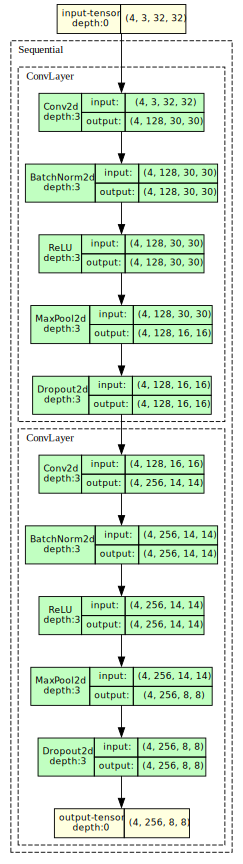


Model Graph:


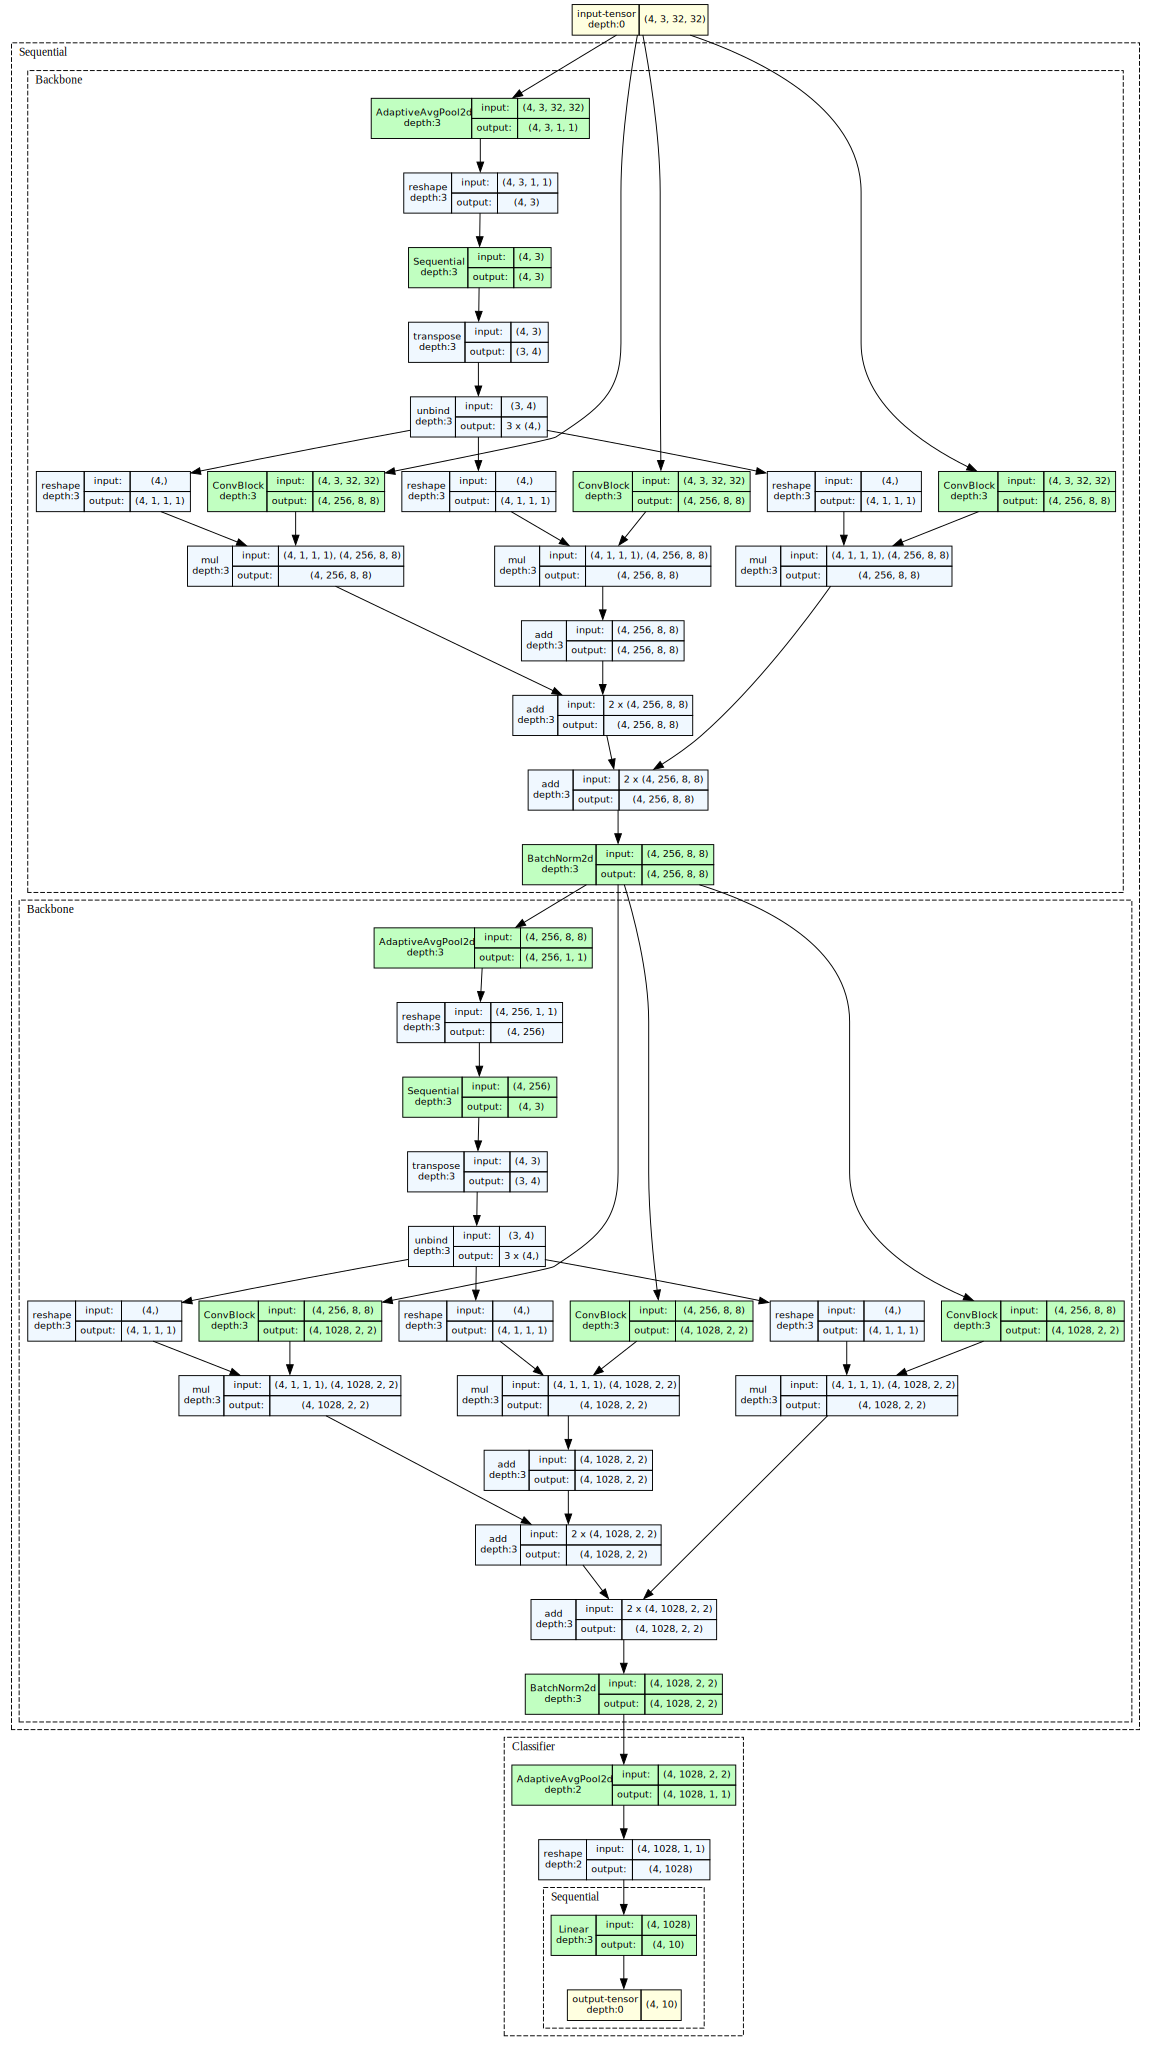

Model(
  (backbones): Sequential(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=True)
        (1): Sigmoid()
      )
      (parallel_conv_blocks): ModuleList(
        (0): ConvBlock(
          (conv_block): Sequential(
            (0): ConvLayer(
              (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
              (4): Dropout2d(p=0.1, inplace=False)
            )
            (1): ConvLayer(
              (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=

In [17]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
#channels = [IMG_CHANNELS, 16, 64, 256]#, 512, 1028] 
#channels = [[IMG_CHANNELS, 16, 64], [64, 256, 1028]]
channels = [[IMG_CHANNELS, 128, 256], [256, 512, 1028]]
#channels = [[IMG_CHANNELS, 4, 8], [8, 16, 32], [32, 64, 128], [128, 256, 512], [512, 1024, 1024]]
N = len(channels)
Ks = [3] * N
#Ks = [3, 1]
#
model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')
model.set_debug(False)

model_summary(model=model, trainloader=trainloader)
model

### 4.2 Loss Function

In [18]:
# Cross Entropy loss is used for classification problem
criterion = nn.CrossEntropyLoss()

### 4.3 Optimzer

In [19]:
# Init optimizer 
WEIGHT_DECAY = 1e-4 #0.05 # 0.15
LR = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

### 4.4 Learning Rate Schedulers

In [20]:
def visualise_lr(scheduler, epochs = 20):
    """
    Method to help visualize the Learning rate.
    """
    lrs_ = list()
    values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
    print(values)
    for i in range(epochs):
        #for j in range(len(trainloader)):
        optimizer.step()
        scheduler.step(values[i])
        #scheduler.step()
        #lrs_.append(scheduler.get_last_lr())
        lrs_.append(optimizer.param_groups[0]['lr'])

    fig, ax = plt.subplots(1)
    ax.scatter(range(len(lrs_)), lrs_)
    ax.set_yscale('log')
    fig.show()

    
def init_scheduler(optimizer, lr, scheduler_name):
    schedulers = dict()
    
    schedulers["constant_scheduler"] = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=20)
    schedulers["linear_scheduler"] = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=50, last_epoch=- 1, verbose=False)
    schedulers["polynomial_scheduler"] = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=50, power=2.0, last_epoch=- 1, verbose=False)
    schedulers["exponential_scheduler"] = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    schedulers["step_scheduler"] = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    schedulers["cyclic_scheduler"] = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
    schedulers["one_cycle_scheduler"] = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=20, steps_per_epoch=len(trainloader), pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=False)
    schedulers["one_cycle_scheduler"] = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=50, )#epochs=20, steps_per_epoch=len(trainloader), )
    #schedulers["reduce_on_plateau_scheduler"] = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=7, steps_per_epoch=len(trainloader))
    
    schedulers["reduce_on_plateau_scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

    #schedulers["sequential_scheduler"] = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[schedulers["polynomial_scheduler"], schedulers["cyclic_scheduler"]], milestones=[20])#, last_epoch=60)

    optimizer.param_groups[0]['lr'] = lr
    
    return schedulers[scheduler_name]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


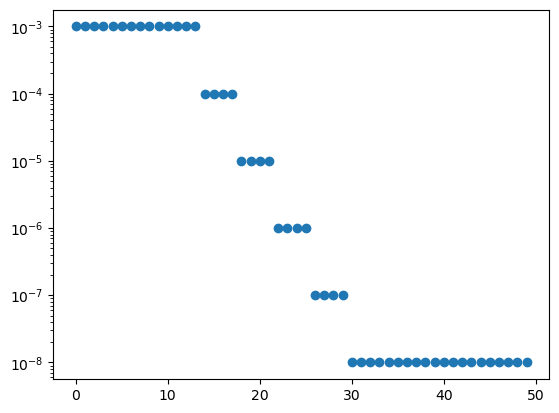

In [21]:
visualise_lr(scheduler=init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler"), epochs=50)

### 4.5 Init Scheduler

In [22]:
scheduler = init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler")

### 4.6 Init Trainer

In [23]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

### 4.7 Train

Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.272
[1,    98] loss: 1.643
[1,   147] loss: 1.508
[1,   196] loss: 1.399
LR : 0.00100000 | Train Loss : 1.71 | Train Accuracy : 41.78 | Test Loss : 1.23 | Test Accuracy : 56.54


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.335
[2,    98] loss: 1.234
[2,   147] loss: 1.175
[2,   196] loss: 1.155
LR : 0.00100000 | Train Loss : 1.23 | Train Accuracy : 56.90 | Test Loss : 0.97 | Test Accuracy : 66.41


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.065
[3,    98] loss: 1.035
[3,   147] loss: 0.990
[3,   196] loss: 0.966
LR : 0.00100000 | Train Loss : 1.01 | Train Accuracy : 64.58 | Test Loss : 0.86 | Test Accuracy : 70.11


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 0.912
[4,    98] loss: 0.909
[4,   147] loss: 0.891
[4,   196] loss: 0.846
LR : 0.00100000 | Train Loss : 0.89 | Train Accuracy : 69.03 | Test Loss : 0.76 | Test Accuracy : 74.24


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 0.825
[5,    98] loss: 0.792
[5,   147] loss: 0.800
[5,   196] loss: 0.786
LR : 0.00100000 | Train Loss : 0.80 | Train Accuracy : 72.28 | Test Loss : 0.65 | Test Accuracy : 77.14
Finished Training


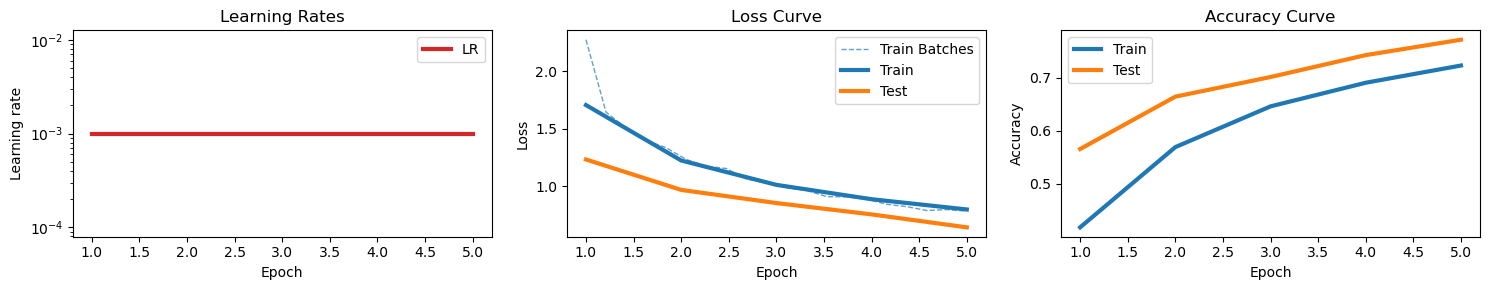

In [24]:
trainer.train(epochs=5, use_gpu=USE_GPU, grad_clip=0.1)
trainer.plot()

Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 0.752
[6,    98] loss: 0.724
[6,   147] loss: 0.734
[6,   196] loss: 0.734
LR : 0.00100000 | Train Loss : 0.74 | Train Accuracy : 74.31 | Test Loss : 0.65 | Test Accuracy : 77.45


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.674
[7,    98] loss: 0.683
[7,   147] loss: 0.694
[7,   196] loss: 0.666
LR : 0.00100000 | Train Loss : 0.68 | Train Accuracy : 76.47 | Test Loss : 0.55 | Test Accuracy : 81.04


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.618
[8,    98] loss: 0.634
[8,   147] loss: 0.643
[8,   196] loss: 0.624
LR : 0.00100000 | Train Loss : 0.63 | Train Accuracy : 77.98 | Test Loss : 0.56 | Test Accuracy : 80.99


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.597
[9,    98] loss: 0.596
[9,   147] loss: 0.604
[9,   196] loss: 0.590
LR : 0.00100000 | Train Loss : 0.60 | Train Accuracy : 79.39 | Test Loss : 0.50 | Test Accuracy : 82.65


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.557
[10,    98] loss: 0.566
[10,   147] loss: 0.555
[10,   196] loss: 0.556
LR : 0.00100000 | Train Loss : 0.56 | Train Accuracy : 80.37 | Test Loss : 0.50 | Test Accuracy : 82.37


Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.516
[11,    98] loss: 0.538
[11,   147] loss: 0.547
[11,   196] loss: 0.523
LR : 0.00100000 | Train Loss : 0.53 | Train Accuracy : 81.56 | Test Loss : 0.46 | Test Accuracy : 84.22


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.493
[12,    98] loss: 0.494
[12,   147] loss: 0.502
[12,   196] loss: 0.496
LR : 0.00100000 | Train Loss : 0.50 | Train Accuracy : 82.65 | Test Loss : 0.49 | Test Accuracy : 83.54


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.464
[13,    98] loss: 0.470
[13,   147] loss: 0.473
[13,   196] loss: 0.474
LR : 0.00100000 | Train Loss : 0.47 | Train Accuracy : 83.70 | Test Loss : 0.44 | Test Accuracy : 84.68


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.447
[14,    98] loss: 0.449
[14,   147] loss: 0.443
[14,   196] loss: 0.462
LR : 0.00100000 | Train Loss : 0.45 | Train Accuracy : 84.30 | Test Loss : 0.46 | Test Accuracy : 84.34


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.420
[15,    98] loss: 0.425
[15,   147] loss: 0.435
[15,   196] loss: 0.432
LR : 0.00100000 | Train Loss : 0.43 | Train Accuracy : 85.15 | Test Loss : 0.43 | Test Accuracy : 85.61


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.392
[16,    98] loss: 0.390
[16,   147] loss: 0.406
[16,   196] loss: 0.402
LR : 0.00100000 | Train Loss : 0.40 | Train Accuracy : 86.01 | Test Loss : 0.42 | Test Accuracy : 86.22


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.392
[17,    98] loss: 0.396
[17,   147] loss: 0.387
[17,   196] loss: 0.396
LR : 0.00100000 | Train Loss : 0.39 | Train Accuracy : 86.18 | Test Loss : 0.40 | Test Accuracy : 86.62


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.381
[18,    98] loss: 0.356
[18,   147] loss: 0.357
[18,   196] loss: 0.371
LR : 0.00100000 | Train Loss : 0.37 | Train Accuracy : 87.20 | Test Loss : 0.40 | Test Accuracy : 86.87


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.342
[19,    98] loss: 0.354
[19,   147] loss: 0.348
[19,   196] loss: 0.366
LR : 0.00100000 | Train Loss : 0.35 | Train Accuracy : 87.69 | Test Loss : 0.37 | Test Accuracy : 87.73


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.333
[20,    98] loss: 0.320
[20,   147] loss: 0.332
[20,   196] loss: 0.335
LR : 0.00100000 | Train Loss : 0.33 | Train Accuracy : 88.40 | Test Loss : 0.38 | Test Accuracy : 87.06


Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.303
[21,    98] loss: 0.307
[21,   147] loss: 0.319
[21,   196] loss: 0.324
LR : 0.00100000 | Train Loss : 0.31 | Train Accuracy : 88.98 | Test Loss : 0.38 | Test Accuracy : 87.13


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.283
[22,    98] loss: 0.312
[22,   147] loss: 0.303
[22,   196] loss: 0.311
LR : 0.00100000 | Train Loss : 0.30 | Train Accuracy : 89.45 | Test Loss : 0.37 | Test Accuracy : 87.52


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.274
[23,    98] loss: 0.285
[23,   147] loss: 0.280
[23,   196] loss: 0.298
LR : 0.00100000 | Train Loss : 0.28 | Train Accuracy : 90.07 | Test Loss : 0.38 | Test Accuracy : 87.87


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.245
[24,    98] loss: 0.206
[24,   147] loss: 0.219
[24,   196] loss: 0.205
LR : 0.00010000 | Train Loss : 0.22 | Train Accuracy : 92.48 | Test Loss : 0.32 | Test Accuracy : 89.49


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.201
[25,    98] loss: 0.195
[25,   147] loss: 0.193
[25,   196] loss: 0.191
LR : 0.00010000 | Train Loss : 0.19 | Train Accuracy : 93.43 | Test Loss : 0.31 | Test Accuracy : 89.63


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.189
[26,    98] loss: 0.189
[26,   147] loss: 0.183
[26,   196] loss: 0.184
LR : 0.00010000 | Train Loss : 0.19 | Train Accuracy : 93.64 | Test Loss : 0.31 | Test Accuracy : 89.72


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.177
[27,    98] loss: 0.171
[27,   147] loss: 0.183
[27,   196] loss: 0.178
LR : 0.00010000 | Train Loss : 0.18 | Train Accuracy : 94.07 | Test Loss : 0.31 | Test Accuracy : 89.77


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.170
[28,    98] loss: 0.178
[28,   147] loss: 0.166
[28,   196] loss: 0.165
LR : 0.00010000 | Train Loss : 0.17 | Train Accuracy : 94.28 | Test Loss : 0.31 | Test Accuracy : 89.89


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.159
[29,    98] loss: 0.168
[29,   147] loss: 0.171
[29,   196] loss: 0.169
LR : 0.00010000 | Train Loss : 0.17 | Train Accuracy : 94.46 | Test Loss : 0.31 | Test Accuracy : 90.15


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.161
[30,    98] loss: 0.163
[30,   147] loss: 0.164
[30,   196] loss: 0.162
LR : 0.00010000 | Train Loss : 0.16 | Train Accuracy : 94.47 | Test Loss : 0.31 | Test Accuracy : 90.06


Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.151
[31,    98] loss: 0.166
[31,   147] loss: 0.161
[31,   196] loss: 0.151
LR : 0.00010000 | Train Loss : 0.16 | Train Accuracy : 94.76 | Test Loss : 0.31 | Test Accuracy : 90.07


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.154
[32,    98] loss: 0.162
[32,   147] loss: 0.156
[32,   196] loss: 0.150
LR : 0.00010000 | Train Loss : 0.16 | Train Accuracy : 94.76 | Test Loss : 0.31 | Test Accuracy : 90.06


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.147
[33,    98] loss: 0.150
[33,   147] loss: 0.150
[33,   196] loss: 0.146
LR : 0.00010000 | Train Loss : 0.15 | Train Accuracy : 95.00 | Test Loss : 0.30 | Test Accuracy : 89.94


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.143
[34,    98] loss: 0.147
[34,   147] loss: 0.145
[34,   196] loss: 0.149
LR : 0.00010000 | Train Loss : 0.15 | Train Accuracy : 95.04 | Test Loss : 0.31 | Test Accuracy : 90.02


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.144
[35,    98] loss: 0.143
[35,   147] loss: 0.146
[35,   196] loss: 0.140
LR : 0.00010000 | Train Loss : 0.14 | Train Accuracy : 95.08 | Test Loss : 0.31 | Test Accuracy : 90.07


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.136
[36,    98] loss: 0.138
[36,   147] loss: 0.136
[36,   196] loss: 0.137
LR : 0.00010000 | Train Loss : 0.14 | Train Accuracy : 95.32 | Test Loss : 0.31 | Test Accuracy : 89.96


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.129
[37,    98] loss: 0.134
[37,   147] loss: 0.134
[37,   196] loss: 0.127
LR : 0.00010000 | Train Loss : 0.13 | Train Accuracy : 95.65 | Test Loss : 0.30 | Test Accuracy : 90.27


Epoch 38 :   0%|          | 0/196 [00:00<?, ?it/s]

[38,    49] loss: 0.127
[38,    98] loss: 0.123
[38,   147] loss: 0.129
[38,   196] loss: 0.122
LR : 0.00001000 | Train Loss : 0.13 | Train Accuracy : 95.69 | Test Loss : 0.31 | Test Accuracy : 90.34


Epoch 39 :   0%|          | 0/196 [00:00<?, ?it/s]

[39,    49] loss: 0.126
[39,    98] loss: 0.129
[39,   147] loss: 0.125
[39,   196] loss: 0.127
LR : 0.00001000 | Train Loss : 0.13 | Train Accuracy : 95.67 | Test Loss : 0.31 | Test Accuracy : 90.18


Epoch 40 :   0%|          | 0/196 [00:00<?, ?it/s]

[40,    49] loss: 0.123
[40,    98] loss: 0.129
[40,   147] loss: 0.125
[40,   196] loss: 0.118
LR : 0.00001000 | Train Loss : 0.12 | Train Accuracy : 95.87 | Test Loss : 0.30 | Test Accuracy : 90.29


Epoch 41 :   0%|          | 0/196 [00:00<?, ?it/s]

[41,    49] loss: 0.122
[41,    98] loss: 0.127
[41,   147] loss: 0.124
[41,   196] loss: 0.122
LR : 0.00001000 | Train Loss : 0.12 | Train Accuracy : 95.81 | Test Loss : 0.30 | Test Accuracy : 90.23


Epoch 42 :   0%|          | 0/196 [00:00<?, ?it/s]

[42,    49] loss: 0.123
[42,    98] loss: 0.124
[42,   147] loss: 0.130
[42,   196] loss: 0.122
LR : 0.00001000 | Train Loss : 0.12 | Train Accuracy : 95.80 | Test Loss : 0.31 | Test Accuracy : 90.25


Epoch 43 :   0%|          | 0/196 [00:00<?, ?it/s]

[43,    49] loss: 0.125
[43,    98] loss: 0.122
[43,   147] loss: 0.118
[43,   196] loss: 0.118
LR : 0.00001000 | Train Loss : 0.12 | Train Accuracy : 95.91 | Test Loss : 0.30 | Test Accuracy : 90.28


Epoch 44 :   0%|          | 0/196 [00:00<?, ?it/s]

[44,    49] loss: 0.123
[44,    98] loss: 0.129
[44,   147] loss: 0.115
[44,   196] loss: 0.119
LR : 0.00001000 | Train Loss : 0.12 | Train Accuracy : 95.83 | Test Loss : 0.30 | Test Accuracy : 90.39


Epoch 45 :   0%|          | 0/196 [00:00<?, ?it/s]

[45,    49] loss: 0.116
[45,    98] loss: 0.121
[45,   147] loss: 0.121
[45,   196] loss: 0.125
LR : 0.00000100 | Train Loss : 0.12 | Train Accuracy : 95.99 | Test Loss : 0.31 | Test Accuracy : 90.23


Epoch 46 :   0%|          | 0/196 [00:00<?, ?it/s]

[46,    49] loss: 0.120
[46,    98] loss: 0.118
[46,   147] loss: 0.124
[46,   196] loss: 0.116
LR : 0.00000100 | Train Loss : 0.12 | Train Accuracy : 95.96 | Test Loss : 0.31 | Test Accuracy : 90.27


Epoch 47 :   0%|          | 0/196 [00:00<?, ?it/s]

[47,    49] loss: 0.121
[47,    98] loss: 0.122
[47,   147] loss: 0.121
[47,   196] loss: 0.120
LR : 0.00000100 | Train Loss : 0.12 | Train Accuracy : 95.97 | Test Loss : 0.30 | Test Accuracy : 90.35


Epoch 48 :   0%|          | 0/196 [00:00<?, ?it/s]

[48,    49] loss: 0.119
[48,    98] loss: 0.123
[48,   147] loss: 0.119
[48,   196] loss: 0.120
LR : 0.00000100 | Train Loss : 0.12 | Train Accuracy : 96.01 | Test Loss : 0.30 | Test Accuracy : 90.39


Epoch 49 :   0%|          | 0/196 [00:00<?, ?it/s]

[49,    49] loss: 0.120
[49,    98] loss: 0.117
[49,   147] loss: 0.121
[49,   196] loss: 0.119
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 96.05 | Test Loss : 0.30 | Test Accuracy : 90.48


Epoch 50 :   0%|          | 0/196 [00:00<?, ?it/s]

[50,    49] loss: 0.122
[50,    98] loss: 0.122
[50,   147] loss: 0.123
[50,   196] loss: 0.119
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.97 | Test Loss : 0.30 | Test Accuracy : 90.37
Finished Training


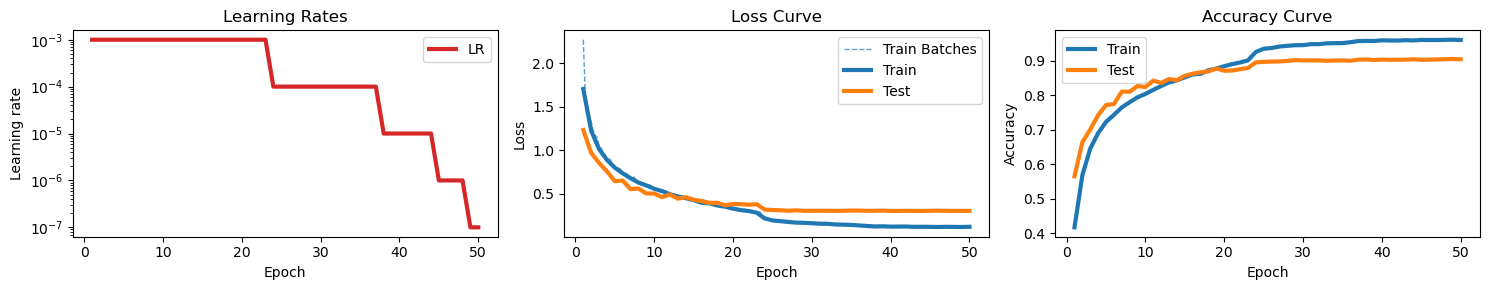

In [25]:
trainer.train(epochs=45, use_gpu=USE_GPU, grad_clip=0.1)
trainer.plot()

In [ ]:
trainer.train(epochs=50, use_gpu=USE_GPU, grad_clip=0.1)
trainer.plot()

Epoch 51 :   0%|          | 0/196 [00:00<?, ?it/s]

[51,    49] loss: 0.122
[51,    98] loss: 0.120
[51,   147] loss: 0.120
[51,   196] loss: 0.123
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.87 | Test Loss : 0.30 | Test Accuracy : 90.40


Epoch 52 :   0%|          | 0/196 [00:00<?, ?it/s]

[52,    49] loss: 0.123
[52,    98] loss: 0.122
[52,   147] loss: 0.122
[52,   196] loss: 0.122
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.91 | Test Loss : 0.30 | Test Accuracy : 90.41


Epoch 53 :   0%|          | 0/196 [00:00<?, ?it/s]

[53,    49] loss: 0.119
[53,    98] loss: 0.125
[53,   147] loss: 0.121
[53,   196] loss: 0.121
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.90 | Test Loss : 0.31 | Test Accuracy : 90.36


Epoch 54 :   0%|          | 0/196 [00:00<?, ?it/s]

[54,    49] loss: 0.119
[54,    98] loss: 0.115
[54,   147] loss: 0.125
[54,   196] loss: 0.118
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 96.07 | Test Loss : 0.30 | Test Accuracy : 90.45


Epoch 55 :   0%|          | 0/196 [00:00<?, ?it/s]

[55,    49] loss: 0.120
[55,    98] loss: 0.121
[55,   147] loss: 0.123
[55,   196] loss: 0.114
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 96.01 | Test Loss : 0.30 | Test Accuracy : 90.43


Epoch 56 :   0%|          | 0/196 [00:00<?, ?it/s]

[56,    49] loss: 0.124
[56,    98] loss: 0.119
[56,   147] loss: 0.119
[56,   196] loss: 0.120
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.99 | Test Loss : 0.30 | Test Accuracy : 90.36


Epoch 57 :   0%|          | 0/196 [00:00<?, ?it/s]

[57,    49] loss: 0.126
[57,    98] loss: 0.116
[57,   147] loss: 0.120
[57,   196] loss: 0.122
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.96 | Test Loss : 0.30 | Test Accuracy : 90.40


Epoch 58 :   0%|          | 0/196 [00:00<?, ?it/s]

[58,    49] loss: 0.119
[58,    98] loss: 0.120
[58,   147] loss: 0.119
[58,   196] loss: 0.121
LR : 0.00000010 | Train Loss : 0.12 | Train Accuracy : 95.94 | Test Loss : 0.30 | Test Accuracy : 90.41


Epoch 59 :   0%|          | 0/196 [00:00<?, ?it/s]

[59,    49] loss: 0.118
[59,    98] loss: 0.121
[59,   147] loss: 0.119
[59,   196] loss: 0.123
LR : 0.00000001 | Train Loss : 0.12 | Train Accuracy : 96.04 | Test Loss : 0.31 | Test Accuracy : 90.33


Epoch 60 :   0%|          | 0/196 [00:00<?, ?it/s]

[60,    49] loss: 0.122
[60,    98] loss: 0.119
[60,   147] loss: 0.121
[60,   196] loss: 0.133
LR : 0.00000001 | Train Loss : 0.12 | Train Accuracy : 95.80 | Test Loss : 0.30 | Test Accuracy : 90.35


Epoch 61 :   0%|          | 0/196 [00:00<?, ?it/s]

[61,    49] loss: 0.116
[61,    98] loss: 0.120
[61,   147] loss: 0.124
[61,   196] loss: 0.127


Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.439
[1,    98] loss: 1.691
[1,   147] loss: 1.533
[1,   196] loss: 1.428
LR : 0.00100000 | Train Loss : 1.77 | Train Accuracy : 40.49 | Test Loss : 1.26 | Test Accuracy : 54.57


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.371
[2,    98] loss: 1.292
[2,   147] loss: 1.237
[2,   196] loss: 1.195
LR : 0.00100000 | Train Loss : 1.27 | Train Accuracy : 55.09 | Test Loss : 0.98 | Test Accuracy : 64.90


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.128
[3,    98] loss: 1.120
[3,   147] loss: 1.091
[3,   196] loss: 1.043
LR : 0.00100000 | Train Loss : 1.10 | Train Accuracy : 61.60 | Test Loss : 0.87 | Test Accuracy : 69.94


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 1.005
[4,    98] loss: 0.979
[4,   147] loss: 0.916
[4,   196] loss: 0.944
LR : 0.00100000 | Train Loss : 0.96 | Train Accuracy : 66.58 | Test Loss : 0.81 | Test Accuracy : 71.73


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 0.908
[5,    98] loss: 0.888
[5,   147] loss: 0.858
[5,   196] loss: 0.847
LR : 0.00100000 | Train Loss : 0.88 | Train Accuracy : 69.58 | Test Loss : 0.72 | Test Accuracy : 75.14
Finished Training


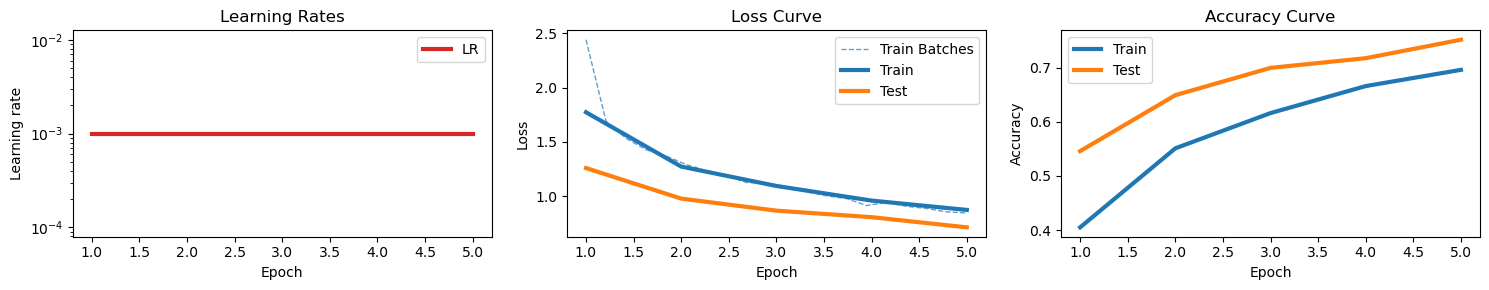

In [110]:
trainer.train(epochs=5, use_gpu=USE_GPU, grad_clip=0.1)
trainer.plot()

In [ ]:
trainer.train(epochs=45, use_gpu=USE_GPU, grad_clip=0.1)
trainer.plot()

Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 0.840
[6,    98] loss: 0.824
[6,   147] loss: 0.818
[6,   196] loss: 0.814
LR : 0.00100000 | Train Loss : 0.82 | Train Accuracy : 71.19 | Test Loss : 0.69 | Test Accuracy : 75.78


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.774
[7,    98] loss: 0.783
[7,   147] loss: 0.776
[7,   196] loss: 0.758
LR : 0.00100000 | Train Loss : 0.77 | Train Accuracy : 73.19 | Test Loss : 0.63 | Test Accuracy : 78.22


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.727
[8,    98] loss: 0.714
[8,   147] loss: 0.717
[8,   196] loss: 0.716
LR : 0.00100000 | Train Loss : 0.72 | Train Accuracy : 75.11 | Test Loss : 0.60 | Test Accuracy : 79.23


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.681
[9,    98] loss: 0.694
[9,   147] loss: 0.695
[9,   196] loss: 0.681
LR : 0.00100000 | Train Loss : 0.69 | Train Accuracy : 75.90 | Test Loss : 0.54 | Test Accuracy : 80.90


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.642
[10,    98] loss: 0.648
[10,   147] loss: 0.645
[10,   196] loss: 0.656
LR : 0.00100000 | Train Loss : 0.65 | Train Accuracy : 77.48 | Test Loss : 0.55 | Test Accuracy : 81.62


Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.623
[11,    98] loss: 0.619
[11,   147] loss: 0.622
[11,   196] loss: 0.624
LR : 0.00100000 | Train Loss : 0.62 | Train Accuracy : 78.19 | Test Loss : 0.52 | Test Accuracy : 81.72


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.599
[12,    98] loss: 0.578
[12,   147] loss: 0.582
[12,   196] loss: 0.589
LR : 0.00100000 | Train Loss : 0.59 | Train Accuracy : 79.53 | Test Loss : 0.51 | Test Accuracy : 82.80


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.549
[13,    98] loss: 0.554
[13,   147] loss: 0.587
[13,   196] loss: 0.563
LR : 0.00100000 | Train Loss : 0.56 | Train Accuracy : 80.44 | Test Loss : 0.48 | Test Accuracy : 83.10


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.550
[14,    98] loss: 0.546
[14,   147] loss: 0.561
[14,   196] loss: 0.541
LR : 0.00100000 | Train Loss : 0.55 | Train Accuracy : 80.72 | Test Loss : 0.49 | Test Accuracy : 83.50


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.525
[15,    98] loss: 0.531
[15,   147] loss: 0.511
[15,   196] loss: 0.523
LR : 0.00100000 | Train Loss : 0.52 | Train Accuracy : 81.52 | Test Loss : 0.48 | Test Accuracy : 83.72


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.503
[16,    98] loss: 0.503
[16,   147] loss: 0.497
[16,   196] loss: 0.526
LR : 0.00100000 | Train Loss : 0.51 | Train Accuracy : 82.51 | Test Loss : 0.48 | Test Accuracy : 84.41


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.467
[17,    98] loss: 0.484
[17,   147] loss: 0.485
[17,   196] loss: 0.481
LR : 0.00100000 | Train Loss : 0.48 | Train Accuracy : 83.16 | Test Loss : 0.47 | Test Accuracy : 84.25


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.451
[18,    98] loss: 0.452
[18,   147] loss: 0.485
[18,   196] loss: 0.464
LR : 0.00100000 | Train Loss : 0.46 | Train Accuracy : 83.76 | Test Loss : 0.43 | Test Accuracy : 85.57


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.430
[19,    98] loss: 0.439
[19,   147] loss: 0.458
[19,   196] loss: 0.455
LR : 0.00100000 | Train Loss : 0.45 | Train Accuracy : 84.49 | Test Loss : 0.45 | Test Accuracy : 85.23


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.419
[20,    98] loss: 0.429
[20,   147] loss: 0.443
[20,   196] loss: 0.441
LR : 0.00100000 | Train Loss : 0.43 | Train Accuracy : 84.71 | Test Loss : 0.44 | Test Accuracy : 85.32


Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.419
[21,    98] loss: 0.423
[21,   147] loss: 0.425
[21,   196] loss: 0.430
LR : 0.00100000 | Train Loss : 0.42 | Train Accuracy : 85.37 | Test Loss : 0.44 | Test Accuracy : 85.15


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.407
[22,    98] loss: 0.398
[22,   147] loss: 0.404
[22,   196] loss: 0.407
LR : 0.00100000 | Train Loss : 0.40 | Train Accuracy : 85.91 | Test Loss : 0.43 | Test Accuracy : 85.97


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.379
[23,    98] loss: 0.380
[23,   147] loss: 0.387
[23,   196] loss: 0.388
LR : 0.00100000 | Train Loss : 0.38 | Train Accuracy : 86.59 | Test Loss : 0.40 | Test Accuracy : 86.85


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.355
[24,    98] loss: 0.366
[24,   147] loss: 0.378
[24,   196] loss: 0.380
LR : 0.00100000 | Train Loss : 0.37 | Train Accuracy : 86.94 | Test Loss : 0.40 | Test Accuracy : 87.29


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.346
[25,    98] loss: 0.360
[25,   147] loss: 0.377
[25,   196] loss: 0.391
LR : 0.00100000 | Train Loss : 0.37 | Train Accuracy : 87.04 | Test Loss : 0.42 | Test Accuracy : 86.45


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.349
[26,    98] loss: 0.353
[26,   147] loss: 0.351
[26,   196] loss: 0.349
LR : 0.00100000 | Train Loss : 0.35 | Train Accuracy : 87.75 | Test Loss : 0.42 | Test Accuracy : 86.99


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.330
[27,    98] loss: 0.336
[27,   147] loss: 0.332
[27,   196] loss: 0.335
LR : 0.00100000 | Train Loss : 0.33 | Train Accuracy : 88.25 | Test Loss : 0.39 | Test Accuracy : 87.30


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.315
[28,    98] loss: 0.316
[28,   147] loss: 0.319
[28,   196] loss: 0.330
LR : 0.00100000 | Train Loss : 0.32 | Train Accuracy : 88.68 | Test Loss : 0.40 | Test Accuracy : 87.39


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.287
[29,    98] loss: 0.299
[29,   147] loss: 0.307
[29,   196] loss: 0.319
LR : 0.00100000 | Train Loss : 0.30 | Train Accuracy : 89.31 | Test Loss : 0.42 | Test Accuracy : 87.18


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.285
[30,    98] loss: 0.296
[30,   147] loss: 0.296
[30,   196] loss: 0.322
LR : 0.00100000 | Train Loss : 0.30 | Train Accuracy : 89.46 | Test Loss : 0.40 | Test Accuracy : 87.02


Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.268
[31,    98] loss: 0.282
[31,   147] loss: 0.300
[31,   196] loss: 0.288
LR : 0.00100000 | Train Loss : 0.28 | Train Accuracy : 90.11 | Test Loss : 0.38 | Test Accuracy : 87.88


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.267
[32,    98] loss: 0.272
[32,   147] loss: 0.284
[32,   196] loss: 0.271
LR : 0.00100000 | Train Loss : 0.27 | Train Accuracy : 90.28 | Test Loss : 0.39 | Test Accuracy : 87.36


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.258
[33,    98] loss: 0.261
[33,   147] loss: 0.276
[33,   196] loss: 0.270
LR : 0.00100000 | Train Loss : 0.27 | Train Accuracy : 90.52 | Test Loss : 0.39 | Test Accuracy : 87.90


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.244
[34,    98] loss: 0.249
[34,   147] loss: 0.248
[34,   196] loss: 0.261
LR : 0.00100000 | Train Loss : 0.25 | Train Accuracy : 91.20 | Test Loss : 0.38 | Test Accuracy : 88.21


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.236
[35,    98] loss: 0.250
[35,   147] loss: 0.249
[35,   196] loss: 0.268
LR : 0.00100000 | Train Loss : 0.25 | Train Accuracy : 91.22 | Test Loss : 0.40 | Test Accuracy : 87.88


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.231
[36,    98] loss: 0.239
[36,   147] loss: 0.236
[36,   196] loss: 0.245
LR : 0.00100000 | Train Loss : 0.24 | Train Accuracy : 91.75 | Test Loss : 0.41 | Test Accuracy : 87.73


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.220


## Appendix

### ResNET Model: Experiment [Failed]

In [ ]:
class Conv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, pool=True):
        """
        TODO
        """
            
        super(Conv, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
        )
        if pool: self.conv_layer.add_module("pool", nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
    def forward(self, x):
        return self.conv_layer(x)

    
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool=False, ):
        """
        TODO
        """
            
        super(ResNet, self).__init__()
        
        self.resnet = nn.Sequential(
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool),
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool)
        )
        
        
    def forward(self, x):
        return self.resnet(x) + x
    
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        TODO
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            Conv(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[2], out_channels=channels[2], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel_size, pool=True),
            Conv(in_channels=channels[3], out_channels=channels[4], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[4], out_channels=channels[4], kernel_size=kernel_size, pool=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
    def forward(self, x):
        #return self.relu(self.batch_norm(self.conv_block(x) + self.conv(x)))
        return self.conv_block(x)


## Thank you